In [36]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")
%matplotlib inline
''' %matplotlib inline sets the backend of matplotlib to
the 'inline' backend. When using the 'inline' backend,
your matplotlib graphs will be included in your notebook,
next to the code.'''

" %matplotlib inline sets the backend of matplotlib to\nthe 'inline' backend. When using the 'inline' backend,\nyour matplotlib graphs will be included in your notebook,\nnext to the code."

# A bi-character 1-layer NN Language Model
A character level LM predicts the next chracter in a sequence given already seen some sequence of characters before it.

in name.txt we have some names, we want to create a LM to create some new names!

In [37]:
words = open('names.txt', 'r').read().splitlines()

In [38]:
import  torch

In [39]:
'''
To get same results when sampling during different runs.
If you are using cuDNN, you should set the deterministic behavior.
This might make your code quite slow, but might be a good method to check your code and deactivate it later.
'''
torch.backends.cudnn.deterministic = True

In [40]:
# sets takes an input, create a set of all items,
# & doesn't allow duplicates :)
# then we want a sorted list of course, the order matters! 
chars = sorted(list(set(''.join(words))))
# a map or dict:
# start from 1
s_to_i = { s:i for i, s in enumerate(chars, start=1)}
s_to_i['.'] = 0
i_to_s = { i:s for s,i in s_to_i.items()}

In [64]:
import itertools
def plot_heatmap(tensor, nrow, ncol):
    # if tensor.requires_grad:
    #     t = tensor.detach().numpy()
    # plot the heatmap
    plt.figure(figsize=(nrow*0.8,ncol*0.8))
    plt.imshow(tensor.detach().numpy(), cmap= 'Blues')
    # manually write text on each cell (seaborn annot doesn't look good)
    for i, j in itertools.product(range(nrow), range(ncol)):
        # x:col, y:rows, the origin is top left corner, makes bottom <->top
        plt.text(x=j, y=i, s=f'{tensor[i,j].item():.2f}', ha='center', va='center', color='grey')
    plt.axis('off')

## create the training set of bigrams (x,y)

In [41]:
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = s_to_i[ch1]
        idx2 = s_to_i[ch2]
        xs.append(idx1) # input : ch1
        ys.append(idx2) # predict ch2
        # print(ch1, ch2)
xs = torch.tensor(xs)
# ys = torch.Tensor(ys)
ys = torch.tensor(ys)
# print(xs)
# print(ys)
batch_size = xs.shape[0]
print(f'{batch_size=}')
nclass = 27
indim = nclass

batch_size=228146


In [42]:
g = torch.Generator().manual_seed(2147483647)
# ! W requires grad!!!
W = torch.randn(size=(indim,nclass), generator=g, requires_grad=True)

In [43]:
import torch.nn.functional as F

## The whole Training Loop

In [52]:
xenc = F.one_hot(xs, num_classes = 27).float()
lr = 10

for k in range(100):
    
    # Forward path
    logits = xenc @ W # * log counts [b, nclass]
    counts = logits.exp() # * equivalent to counts [b, nclass]
    probs = counts / counts.sum(dim=1 , keepdim=True) #[b, nclass]
     
    loss = -probs[torch.arange(batch_size), ys].log().mean()

    # set the weight grads to None, PyTorch interpret it as 0
    # but None is more efficient
    W.grad = None
    loss.backward()

    # update
    W.data -= lr *W.grad

    print(f'iteration: {k} | loss: {loss.item()}')


iteration: 0 | loss: 2.4691085815429688
iteration: 1 | loss: 2.469078779220581
iteration: 2 | loss: 2.4690494537353516
iteration: 3 | loss: 2.469019889831543
iteration: 4 | loss: 2.4689908027648926
iteration: 5 | loss: 2.468961477279663
iteration: 6 | loss: 2.4689321517944336
iteration: 7 | loss: 2.4689033031463623
iteration: 8 | loss: 2.468874454498291
iteration: 9 | loss: 2.4688456058502197
iteration: 10 | loss: 2.4688167572021484
iteration: 11 | loss: 2.4687883853912354
iteration: 12 | loss: 2.468759775161743
iteration: 13 | loss: 2.468731641769409
iteration: 14 | loss: 2.468703508377075
iteration: 15 | loss: 2.468674898147583
iteration: 16 | loss: 2.468647003173828
iteration: 17 | loss: 2.4686191082000732
iteration: 18 | loss: 2.4685912132263184
iteration: 19 | loss: 2.4685635566711426
iteration: 20 | loss: 2.4685356616973877
iteration: 21 | loss: 2.468508005142212
iteration: 22 | loss: 2.4684810638427734
iteration: 23 | loss: 2.4684534072875977
iteration: 24 | loss: 2.468426227569

## results
- we acheived an ENLL close to the one we get with pure probabilistic bigram model.

- look at the weight, they kind of show which path is more important! 

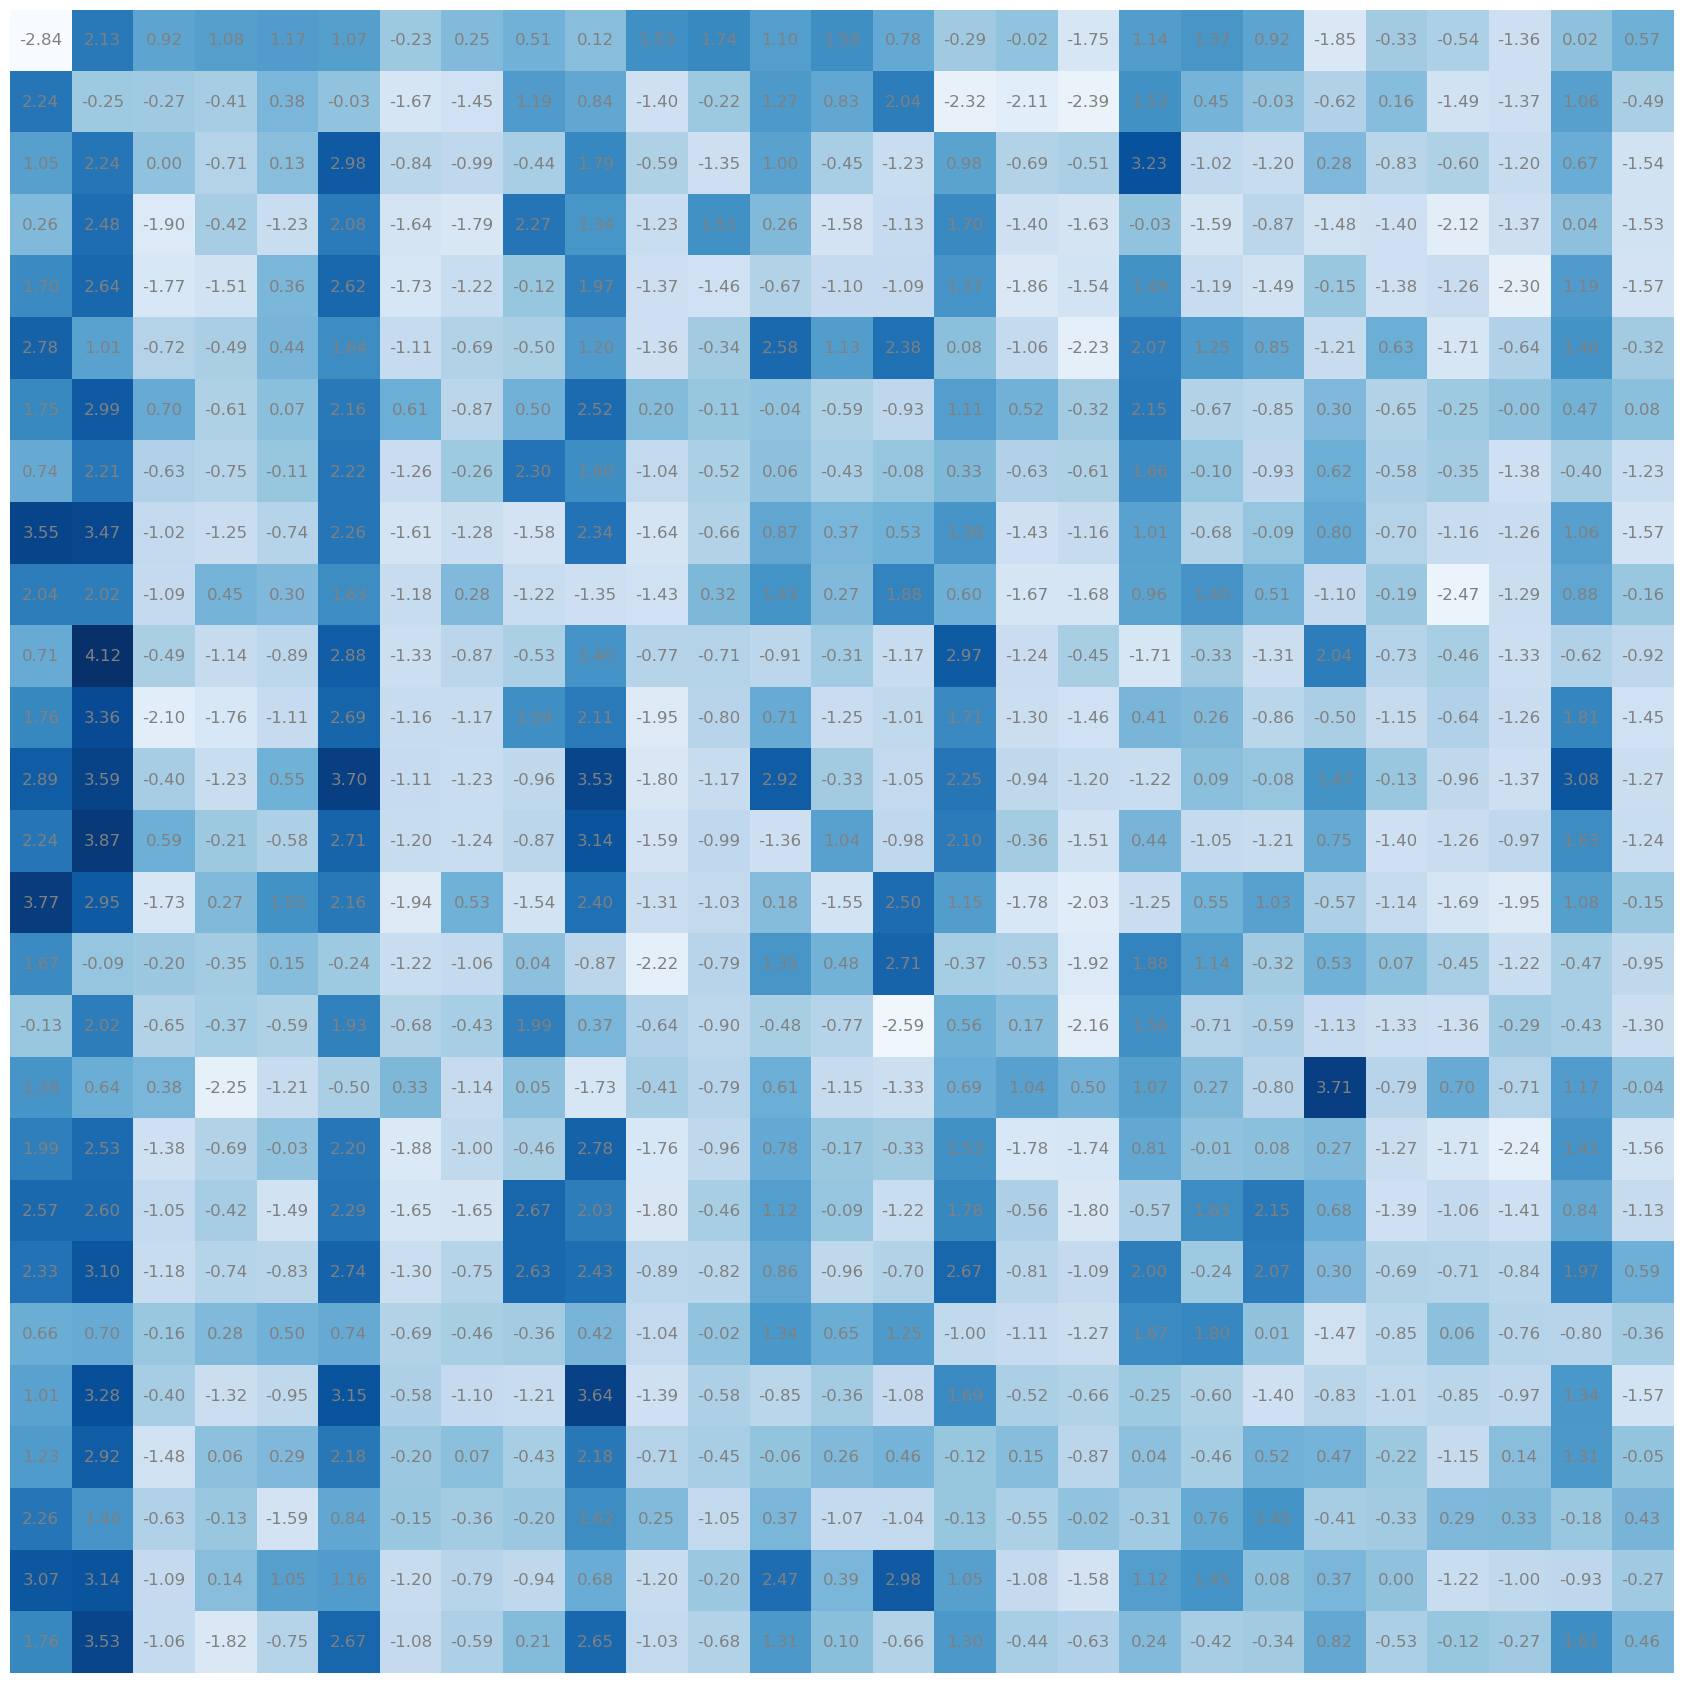

In [65]:
# * row : which of the 27 on-hot inputs - col: which of the 27 outputs
plot_heatmap(W, indim, nclass)

## Regularization, a prior on weights -> MAP Estimation

If we **initialize the weights with zeros, the logits will be zero for all outputs, the exponentiation for all will be 1, then uniform probability. a smooth probability!!

In general, if we force the weights to be low  by L2 norm (like a spring), then we will get a more uniform like output.

In probabilistic Bigram, it's like adding a high fake count to all pairs of characters!

but the Neural Net tries to find the best trade-off, among all pareto optimal solutions. Of course, here you can specify the strength of this L2 norm "spring" with the coefficient. the stronger the l2-norm, the smoother the probabilities (the more fake counts you add)!!

In [79]:
g = torch.Generator().manual_seed(2147483647)
# ! W requires grad!!!
W = torch.randn(size=(indim,nclass), generator=g, requires_grad=True)

In [86]:
xenc = F.one_hot(xs, num_classes = 27).float()
lr = 10
l2coef = 0.1

for k in range(100):
    
    # Forward path
    logits = xenc @ W # * log counts [b, nclass]
    counts = logits.exp() # * equivalent to counts [b, nclass]
    probs = counts / counts.sum(dim=1 , keepdim=True) #[b, nclass]
     
    loss = -probs[torch.arange(batch_size), ys].log().mean() + l2coef*(W**2).mean()

    # set the weight grads to None, PyTorch interpret it as 0
    # but None is more efficient
    W.grad = None
    loss.backward()

    # update
    W.data -= lr *W.grad

    print(f'iteration: {k} | loss: {loss.item()}')

iteration: 0 | loss: 2.586944580078125
iteration: 1 | loss: 2.5869405269622803
iteration: 2 | loss: 2.5869367122650146
iteration: 3 | loss: 2.58693265914917
iteration: 4 | loss: 2.586928606033325
iteration: 5 | loss: 2.5869243144989014
iteration: 6 | loss: 2.586920738220215
iteration: 7 | loss: 2.58691668510437
iteration: 8 | loss: 2.5869126319885254
iteration: 9 | loss: 2.5869085788726807
iteration: 10 | loss: 2.5869052410125732
iteration: 11 | loss: 2.5869014263153076
iteration: 12 | loss: 2.586897373199463
iteration: 13 | loss: 2.5868937969207764
iteration: 14 | loss: 2.58689022064209
iteration: 15 | loss: 2.5868866443634033
iteration: 16 | loss: 2.5868828296661377
iteration: 17 | loss: 2.586879014968872
iteration: 18 | loss: 2.5868756771087646
iteration: 19 | loss: 2.586871862411499
iteration: 20 | loss: 2.5868685245513916
iteration: 21 | loss: 2.586864948272705
iteration: 22 | loss: 2.5868616104125977
iteration: 23 | loss: 2.586857557296753
iteration: 24 | loss: 2.5868544578552246

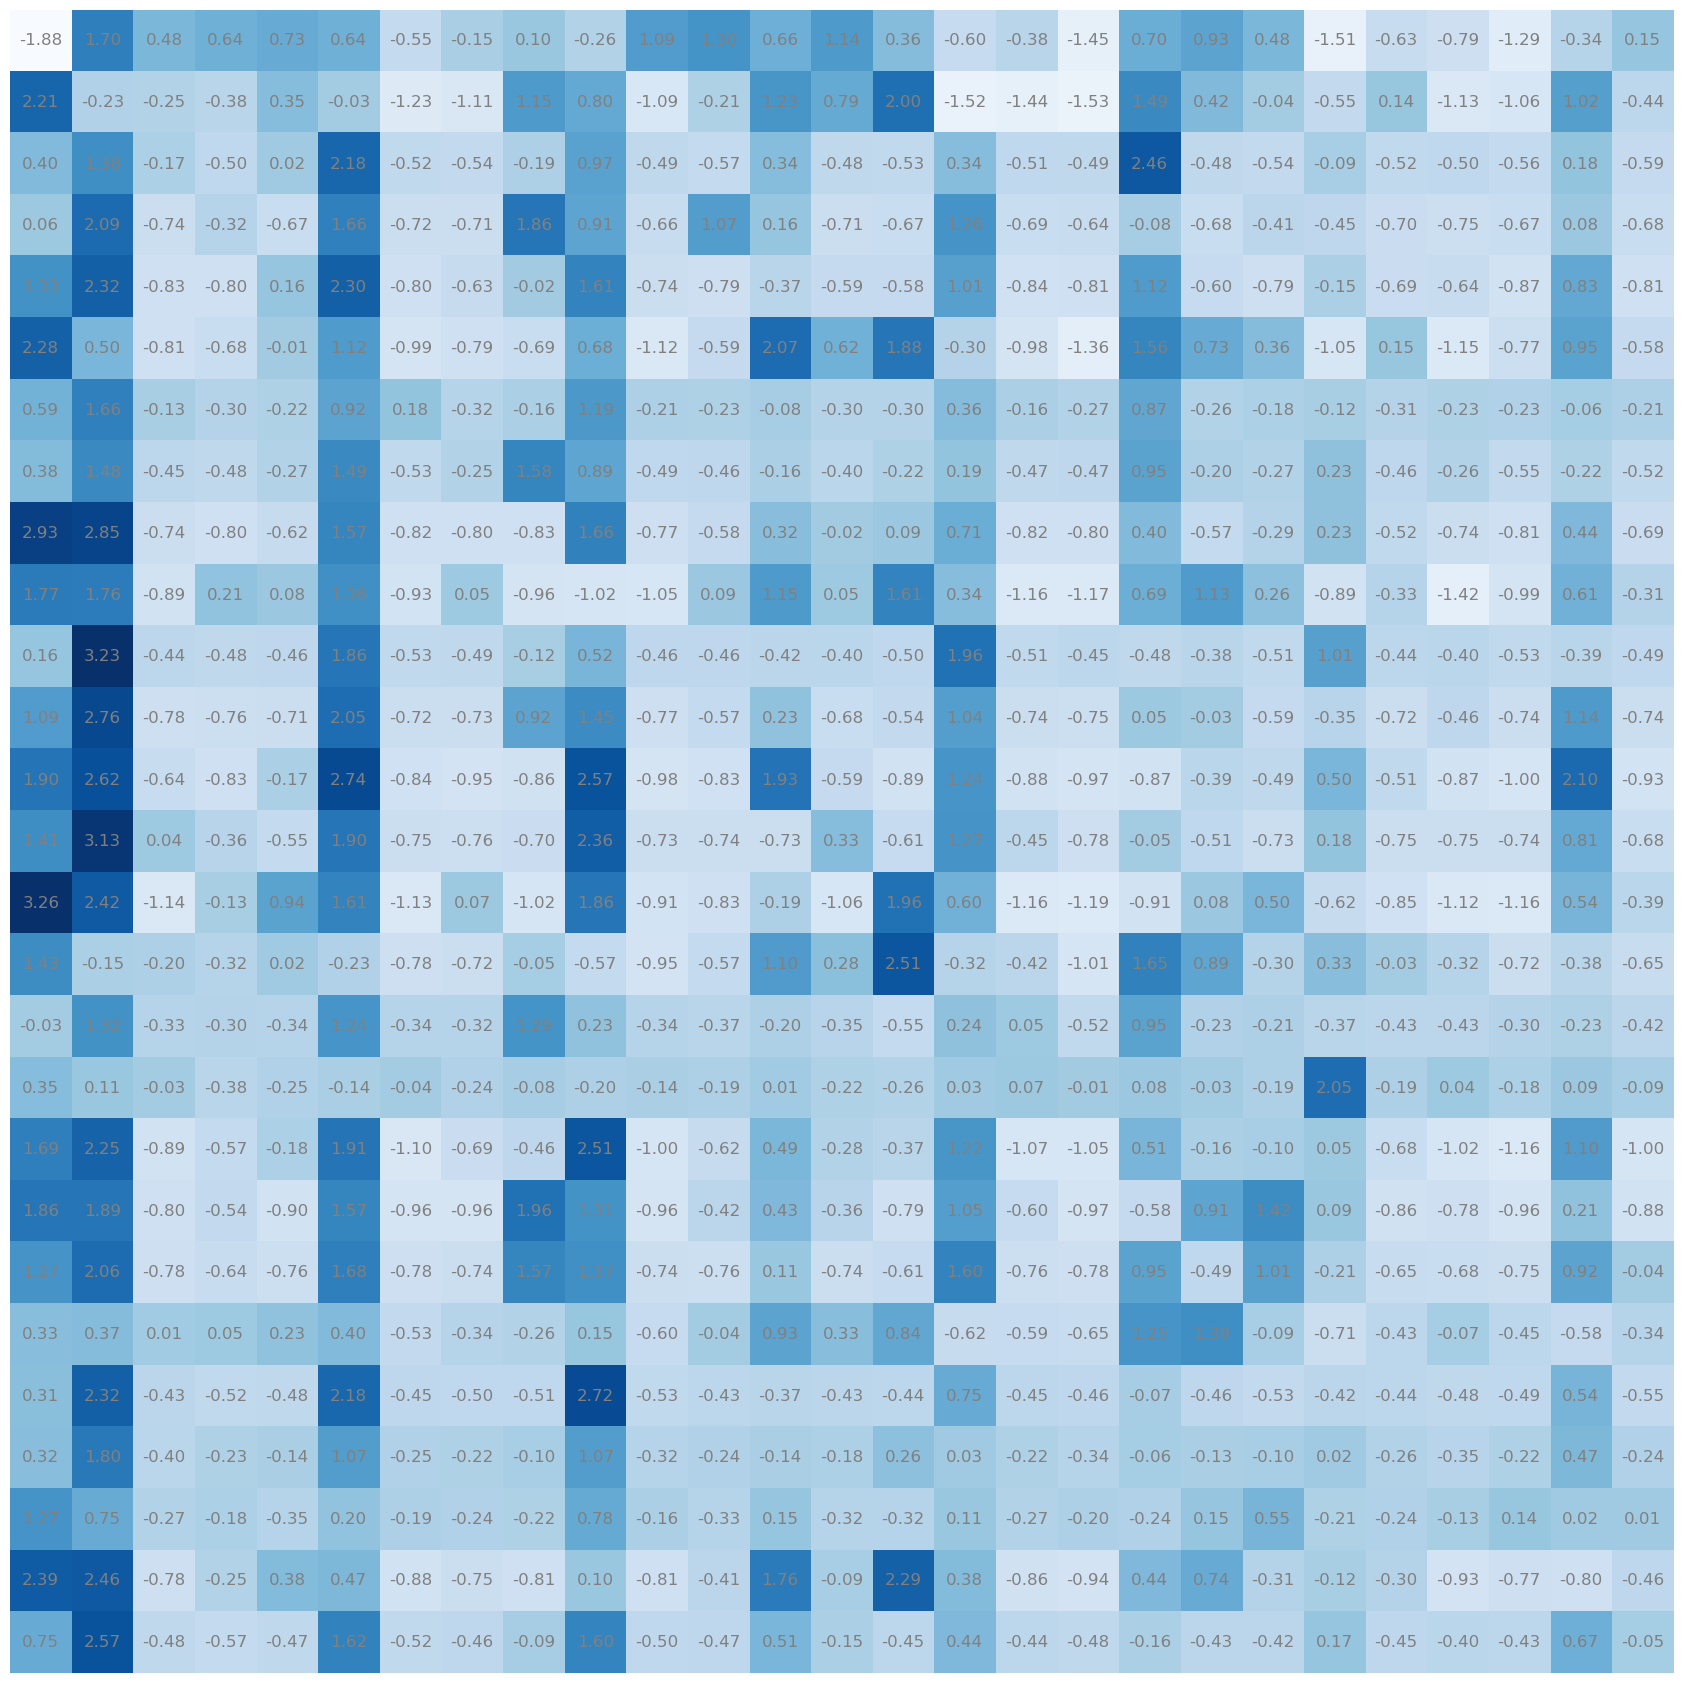

In [87]:
plot_heatmap(W, indim, nclass)

## Let's Generate some samples like Bigram

In [95]:
g = torch.Generator().manual_seed(2147483647)
for _ in range(10):
    idx = 0
    name = ''
    while True:
        # Forward path
        xenc0 = F.one_hot(torch.tensor([idx]), num_classes = 27).float()
        logits = xenc0 @ W # * log counts [b, nclass]
        counts = logits.exp() # * equivalent to counts [b, nclass]
        probs = counts / counts.sum(dim=1 , keepdim=True) #[b, nclass]
        idx = torch.multinomial(probs.detach(), num_samples=1, replacement=True, generator=g).item()
        if idx == 0:
            break
        ch = i_to_s[idx]
        # print(ch)
        name += ch
    print(name)

mor
axx
minaynnnyles
koneraisah
andhunizarie
pberen
iadeesh
h
jlligtien
egyrhm


#### PyTorch Loss-Input Confusion (Cheatsheet)

- `torch.nn.functional.binary_cross_entropy` takes logistic sigmoid values as inputs
- `torch.nn.functional.binary_cross_entropy_with_logits` takes logits as inputs 
- `torch.nn.functional.cross_entropy` takes logits as inputs (performs `log_softmax` internally)
- `torch.nn.functional.nll_loss` is like `cross_entropy` but takes log-probabilities (log-softmax) values as inputs